In [28]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [29]:
contaminated_df = pd.read_csv("../../data/contaminated/data_contaminated3.csv")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [30]:
contaminated_sentences = contaminated_df['combined_text'].tolist()
embeddings = model.encode(contaminated_sentences)
print(embeddings[:5])

[[ 0.28227794  0.12621348 -0.05208312 ... -0.07339635  0.24025863
   0.1327806 ]
 [ 0.43039504  0.03634816 -0.04758246 ... -0.22186738 -0.22349276
   0.06129763]
 [ 0.27479756  0.28263614  0.24597012 ... -0.0940499   0.38327062
   0.55718064]
 [ 0.3451237   0.03631111  0.24890196 ... -0.16847862 -0.6559895
   0.48840496]
 [ 0.35484728  0.07293423  0.34847844 ...  0.02546211  0.13973124
   0.35689235]]


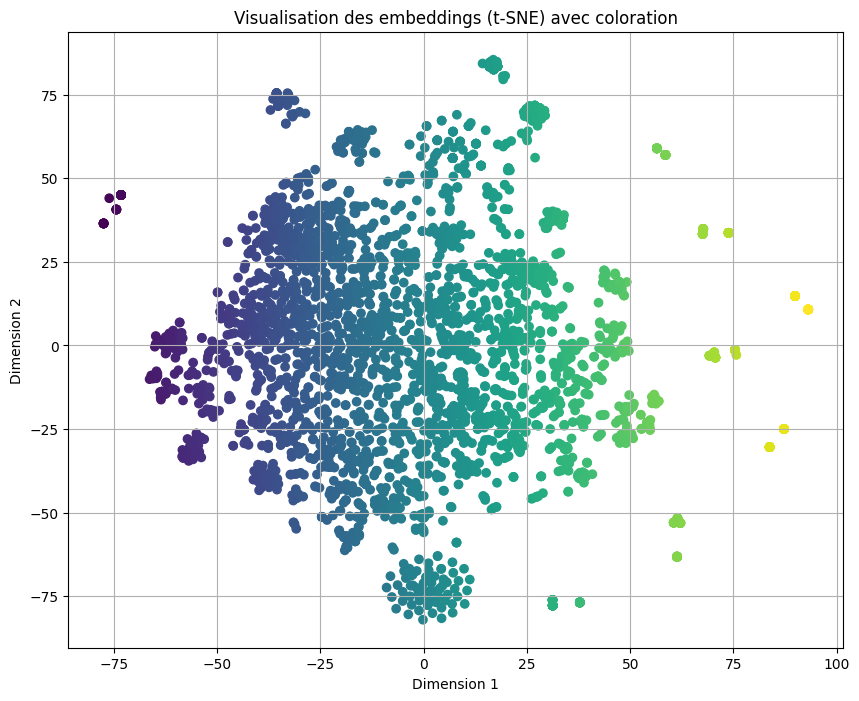

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
reduced_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], c=reduced_2d[:, 0], marker='o')
plt.title('Visualisation des embeddings (t-SNE) avec coloration')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

In [31]:
# Normalisation des données
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

In [32]:
original_indices = np.arange(len(scaled_embeddings))
X_train,X_test = train_test_split(scaled_embeddings, test_size=0.2, random_state=42)

In [33]:
#partie compression de l'entree
input_dim = embeddings.shape[1]
encoding_dim = 32

In [34]:
input_layer = keras.Input(shape=(input_dim,))
# Encodeur
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dense(encoding_dim, activation='relu')(encoder)

# Décodeur
decoder = layers.Dense(64, activation='relu')(encoder)
decoder = layers.Dense(input_dim, activation='sigmoid')(decoder)

In [35]:
# Modèle complet
autoencoder = keras.Model(input_layer, decoder)
encoder_model = keras.Model(input_layer, encoder)
autoencoder.compile(optimizer='adam', loss='mse')

In [36]:
# Entraîner l'auto-encodeur
autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1106 - val_loss: 0.8968
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8808 - val_loss: 0.8316
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8270 - val_loss: 0.7967
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7708 - val_loss: 0.7778
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7718 - val_loss: 0.7645
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7432 - val_loss: 0.7556
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7553 - val_loss: 0.7489
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7401 - val_loss: 0.7439
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7267 - val_loss: 0.7390
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7332 - val_loss: 0.7354
Epoch 11/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7303 - val_loss: 0.7321
Epoch 12/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7199 - val_lo

In [62]:
reconstructed_autoencodeur = autoencoder.predict(scaled_embeddings)
mse = np.mean(np.power(scaled_embeddings - reconstructed_autoencodeur, 2), axis=1)
contaminated_df['reconstruction_error'] = mse
reduced_embeddings = encoder_model.predict(scaled_embeddings)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step


In [59]:
threshold = np.percentile(mse, 88)  # Les % supérieurs sont considérés comme anomalies
anomalies_percentile = mse > threshold

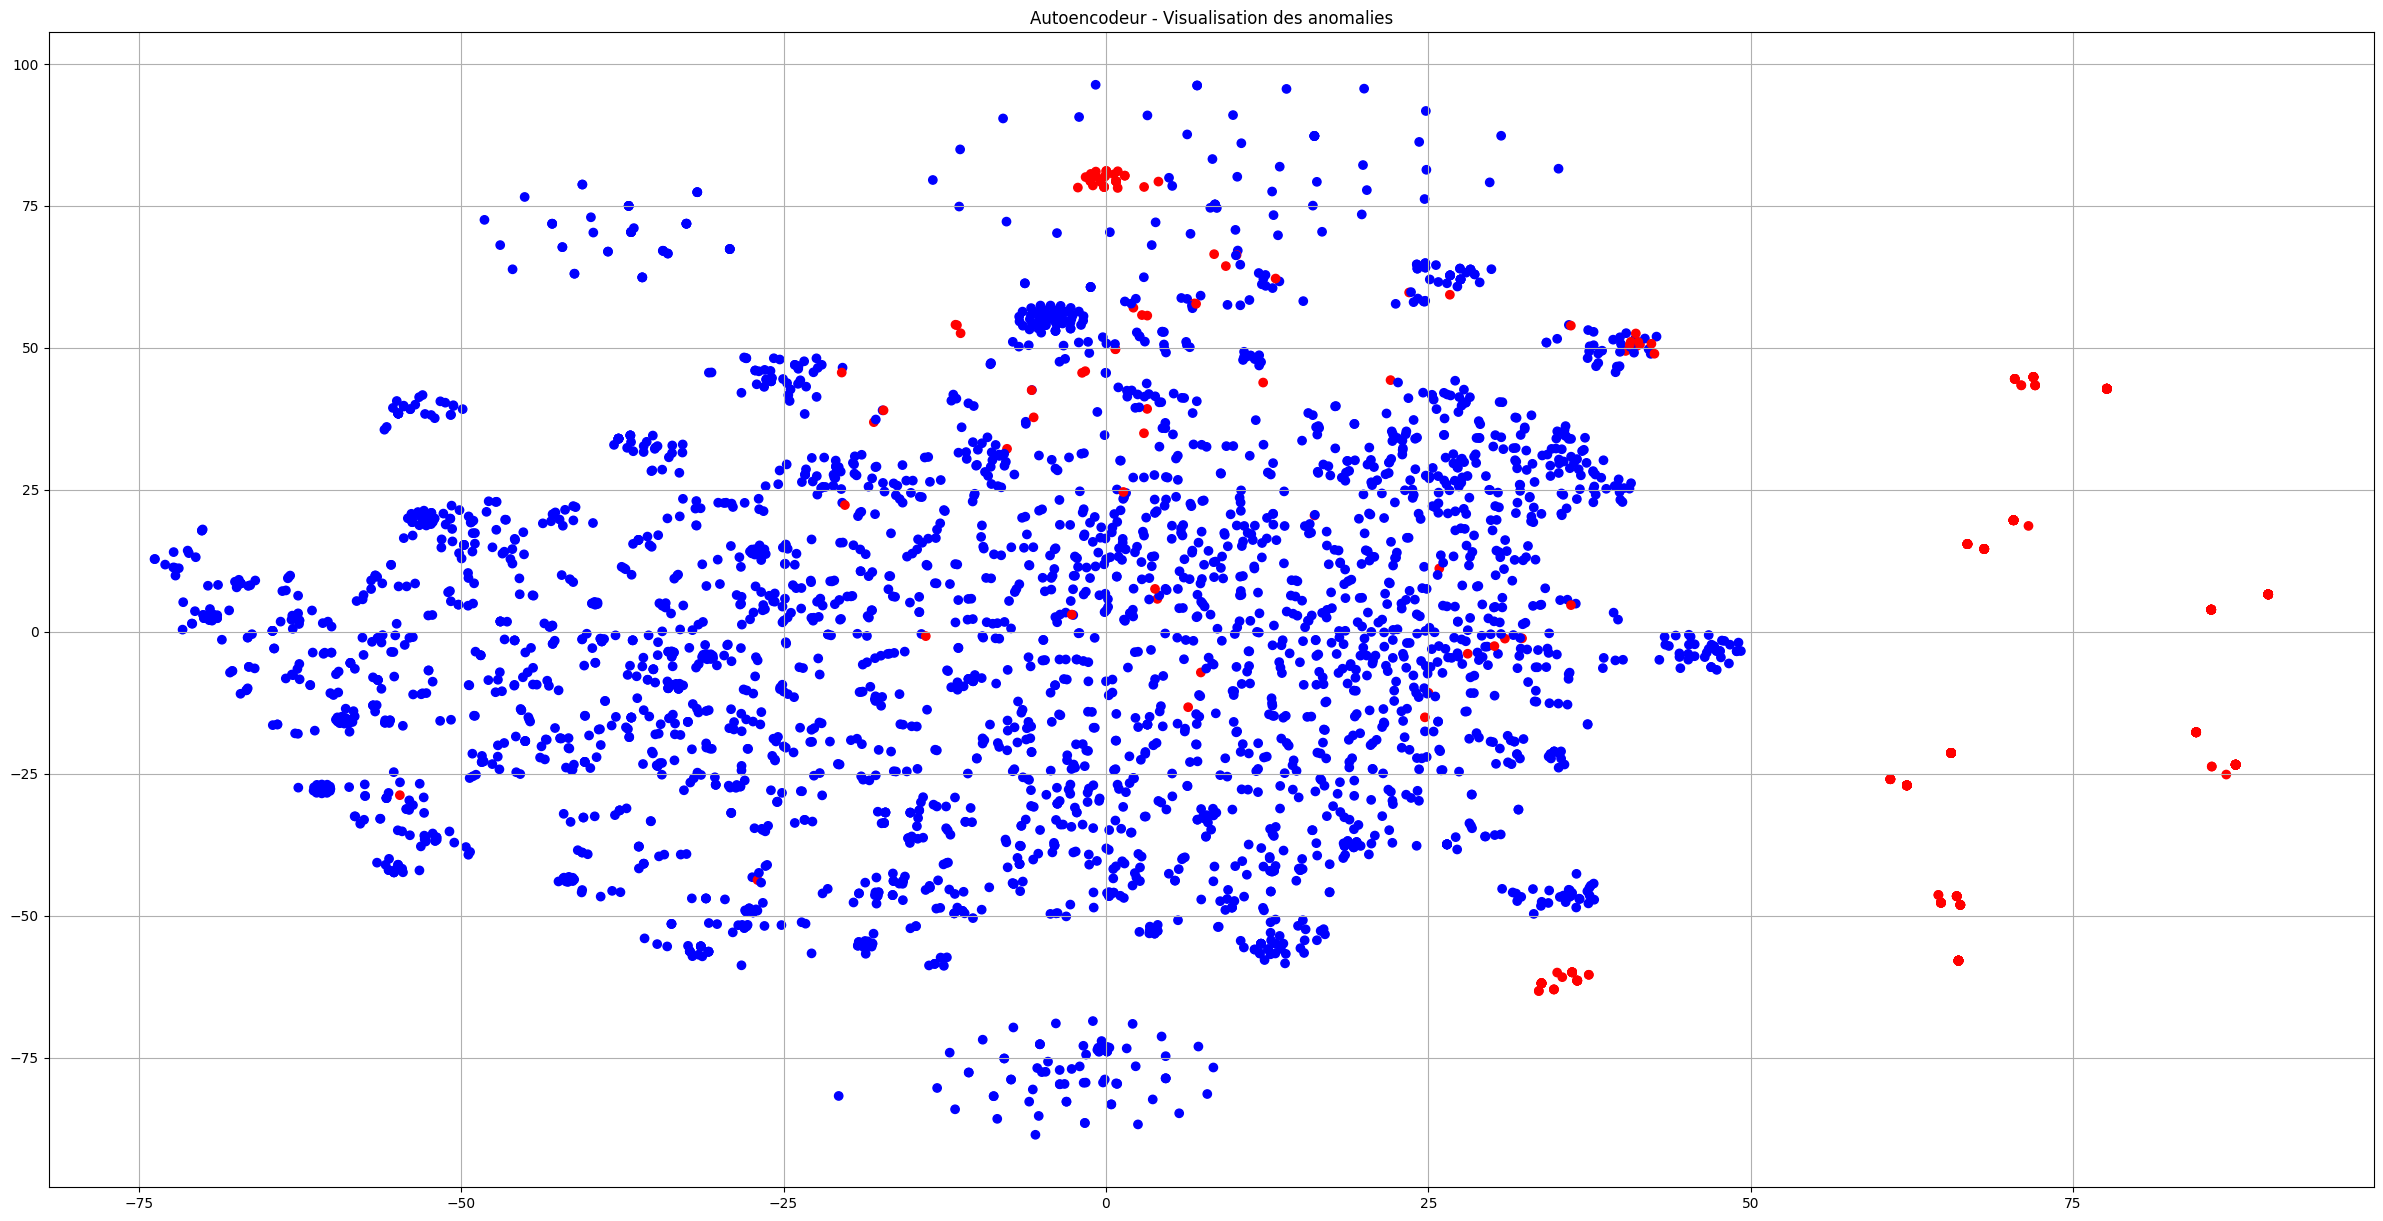

In [63]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
reconstructed_2d = tsne.fit_transform(reconstructed_autoencodeur) 
couleurs = ['b'] * len(scaled_embeddings)
for i in range(len(scaled_embeddings)):
    if mse[i] > threshold:
        couleurs[i] = 'r'

plt.figure(figsize=(30, 15))
plt.scatter(reconstructed_2d[:, 0], reconstructed_2d[:, 1], c=couleurs, marker='o')

plt.title("Autoencodeur - Visualisation des anomalies")
plt.grid(True)
plt.show()


In [42]:
contaminated_df_test = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
isolation_forest.fit(X_train)
i_forest = isolation_forest.predict(X_train)
contaminated_df_test['is_anomaly_iforest'] = isolation_forest.predict(X_train) == -1

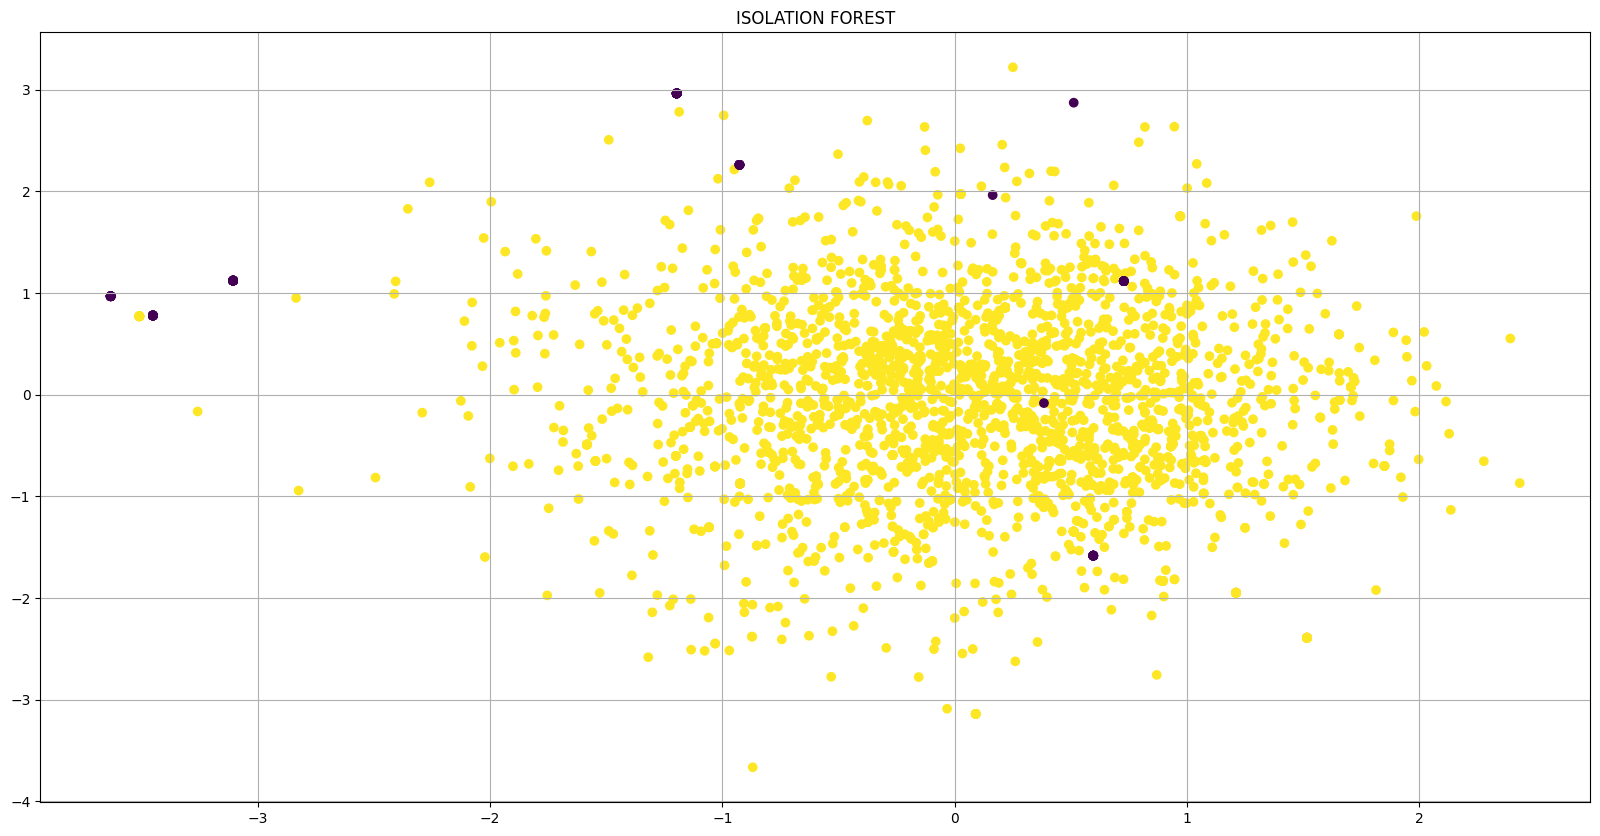

In [56]:
plt.figure(figsize=(20, 10)) 
plt.scatter(X_train[:, 0], X_train[:, 1], c=i_forest, marker='o') 

plt.title("ISOLATION FOREST")
plt.grid(True)
#plt.savefig("output.jpg")
plt.show()


In [44]:
oc_svm = OneClassSVM(nu=0.05, kernel='rbf')
oc_svm.fit(X_train)
osvm = oc_svm.predict(X_train)
contaminated_df_test['is_anomaly_ocsvm'] = oc_svm.predict(X_train) == -1  
anomaly_indices_ocsvm = contaminated_df_test[contaminated_df_test['is_anomaly_ocsvm'] == True].index.tolist()

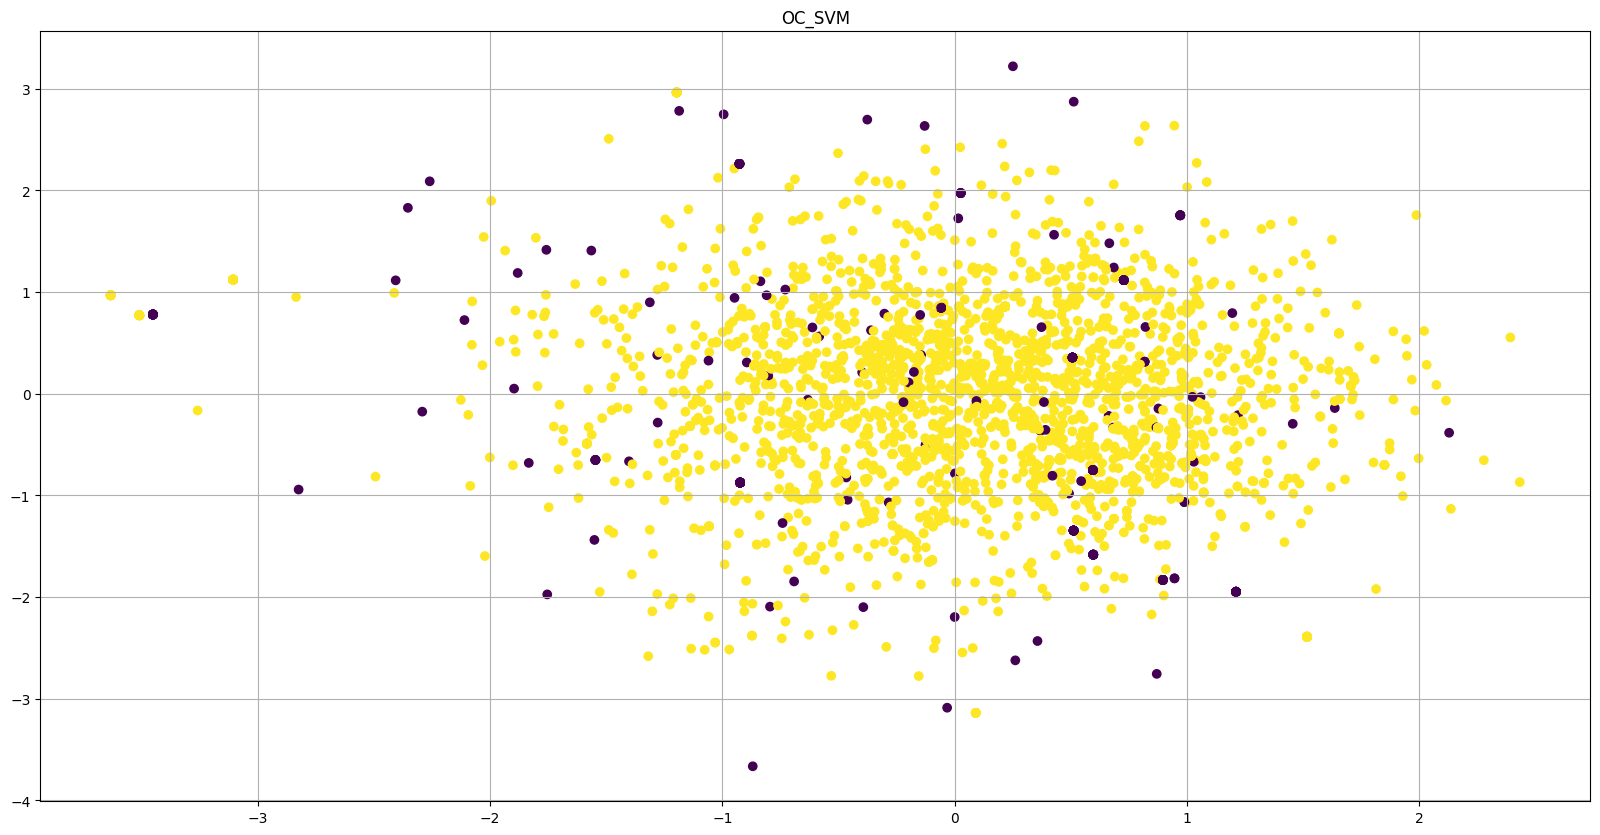

In [55]:
plt.figure(figsize=(20, 10)) 
plt.scatter(X_train[:, 0], X_train[:, 1], c=osvm, marker='o') 

plt.title("OC_SVM")
plt.grid(True)
#plt.savefig("output.jpg")
plt.show()

In [71]:
anomaly_indices_file=("../../data/contaminated/anomaly_indices.csv")

In [88]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import pandas as pd

def evaluate_anomaly_detection_models_non_supervised(X, isolation_forest, oc_svm, autoencoder, anomaly_indices_file):
    """
    Évalue les performances des modèles de détection d'anomalies en utilisant des indices d'anomalies réelles,
    sans avoir besoin d'un ensemble de test ou de labels d'anomalie pour l'entraînement des modèles.
    """
    # Charger les indices des vraies anomalies
    indices_df = pd.read_csv(anomaly_indices_file)
    anomaly_indices_true = indices_df['anomaly_indices'].tolist()

    # Créer le vecteur y_true basé sur les indices d'anomalie fournis
    y_true = np.zeros(len(X))
    anomaly_indices_true = [idx for idx in anomaly_indices_true if idx < len(X)]  # Filtrer les indices hors limites
    y_true[anomaly_indices_true] = 1  # 1 pour anomalie, 0 pour normal

    # Vérifier le nombre d'anomalies
    anomaly_count = np.sum(y_true)
    print(f"Nombre d'anomalies dans l'ensemble de données: {anomaly_count}")
    if anomaly_count == 0:
        print("Attention: Aucune anomalie trouvée dans l'ensemble de données. Vérifiez les indices.")
    
    # Prédictions d'Isolation Forest
    anomaly_indices_iforest = np.where(isolation_forest.predict(X) == -1)[0]
    y_pred_iforest = np.zeros(len(X))
    y_pred_iforest[anomaly_indices_iforest] = 1

    # Prédictions de One-Class SVM
    anomaly_indices_ocsvm = np.where(oc_svm.predict(X) == -1)[0]
    y_pred_ocsvm = np.zeros(len(X))
    y_pred_ocsvm[anomaly_indices_ocsvm] = 1

    # Prédictions de l'Autoencodeur
    reconstructed = autoencoder.predict(X)
    mse = np.mean(np.power(X - reconstructed, 2), axis=1)
    threshold = np.percentile(mse, 95)  # Les 5% supérieurs sont considérés comme anomalies
    anomaly_indices_autoencoder = np.where(mse > threshold)[0]
    y_pred_autoencoder = np.zeros(len(X))
    y_pred_autoencoder[anomaly_indices_autoencoder] = 1

    # Scores pour ROC-AUC
    y_score_iforest = -isolation_forest.score_samples(X)
    y_score_ocsvm = -oc_svm.decision_function(X)
    y_score_autoencoder = mse

    # Calcul des métriques pour chaque modèle
    metrics = {}

    # Calcul de l'accuracy pour chaque modèle
    def calculate_accuracy(y_true, y_pred):
        return accuracy_score(y_true, y_pred)

    # Isolation Forest
    metrics['iforest'] = {
        'precision': precision_score(y_true, y_pred_iforest),
        'recall': recall_score(y_true, y_pred_iforest),
        'f1_score': f1_score(y_true, y_pred_iforest),
        'roc_auc': roc_auc_score(y_true, y_score_iforest),
        'accuracy': calculate_accuracy(y_true, y_pred_iforest)  # Ajouter l'accuracy
    }

    # One-Class SVM
    metrics['ocsvm'] = {
        'precision': precision_score(y_true, y_pred_ocsvm),
        'recall': recall_score(y_true, y_pred_ocsvm),
        'f1_score': f1_score(y_true, y_pred_ocsvm),
        'roc_auc': roc_auc_score(y_true, y_score_ocsvm),
        'accuracy': calculate_accuracy(y_true, y_pred_ocsvm)  # Ajouter l'accuracy
    }

    # Autoencoder
    metrics['autoencoder'] = {
        'precision': precision_score(y_true, y_pred_autoencoder),
        'recall': recall_score(y_true, y_pred_autoencoder),
        'f1_score': f1_score(y_true, y_pred_autoencoder),
        'roc_auc': roc_auc_score(y_true, y_score_autoencoder),
        'accuracy': calculate_accuracy(y_true, y_pred_autoencoder)  # Ajouter l'accuracy
    }
    results_df = pd.DataFrame(metrics).T
    results_df = results_df.round(4)  
    return results_df


In [89]:
evaluate_anomaly_detection_models_non_supervised(X_train, isolation_forest, oc_svm, autoencoder, anomaly_indices_file)

Nombre d'anomalies dans l'ensemble de données: 543.0
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


,precision,recall,f1_score,roc_auc,accuracy
iforest,0.2121,0.0516,0.0830,0.4891,0.7737
ocsvm,0.1779,0.0976,0.1260,0.4932,0.7313
autoencoder,0.2015,0.0497,0.0798,0.4942,0.7722


pour le moment tous les modèles n'ont pas une bonne performance je vais ajuster les paramètres et reessayer après prendre une décision finale 